<a href="https://colab.research.google.com/github/vivianchen98/california_housing_kmeans_clustering/blob/master/sc9by_assignment_3_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Clustering California Housing with K-means

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

![Half of the homes in San Franciso is now one million or above](https://amp.businessinsider.com/images/573de0b88d3eaea27198a55d-960-480.jpg)

In this assignment, you will attempt to cluster the California Housing by implementing and analyzing the k-means algorithm to the data. K-Means is one of the most popular clustering algorithms. K-means stores k-centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. For references, you may refer to my lecture 9 or Chapter 2 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit this Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.

**Note**: In order for your assignment to be graded, you must save your Notebook filename under this format: **yourUvaUserId_assignment_3_kmeans.ipynb**.


---
## 1. PRE-PROCESSING THE DATA (10 pts)

Download the California Housing dataset from the below link. This dataset includes statistics about the median income, median age, average number of rooms per person, average number of persons in a household etc. The statistics were gathered per geographical block.

**Data Acquiring:** Download the dataset from https://www.kaggle.com/camnugent/california-housing-prices

**Data Discovery, Visualization, and Cleaning:** Fortunately, this step have been given to you from chapter 2. However, you should review them and write the code necessary for the purposes of this assignment. 

In [0]:
# You might want to use the following package
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


import numpy as np
import random
import pandas as pd # Pandas module to enable data manipulation
from sklearn import metrics
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [0]:
# get the data from url
DOWNLOAD_URL = "https://raw.githubusercontent.com/vivianchen98/california_housing_kmeans_clustering/master/housing.csv"

# get the data
housing = pd.read_csv(DOWNLOAD_URL)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

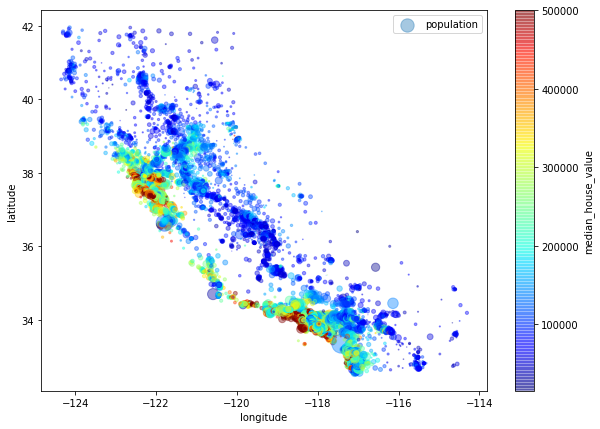

In [0]:
# Discover and visualize data
# Incorporate the population into the circle size
# Add color (jet map) for the value of the housing
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
# save_fig("housing_prices_scatterplot")

In [0]:
# Data cleaning

# build pipeline to treat numerical and categorical data separately
num_pipeline = Pipeline([
              ('imputer', SimpleImputer(strategy="median")),
              ('std_scaler', StandardScaler()),
])

housing_num = housing.drop("ocean_proximity", axis=1)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
              ('num', num_pipeline, num_attribs),
              ("cat", OneHotEncoder(), cat_attribs),
])

In [0]:
# treat missing data
housing = housing.dropna()
sample_incomplete_rows = housing[housing.isnull().any(axis=1)]

# use the pipeline to the dataset
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(20433, 14)

- - -
## 2. IMPLEMENTING K-MEANS (40 pts)

You must implement your own version of K-Means Algorithm. Input a cluster count K and M data points each with its own vector of N features, along with the choice of a distance measure; then:

1. Initialize K centroids. In our case, a centroid is just the average of all data in a cluster.
2. Assign each data point to the cluster that has the closest centroid base on a **distance measure** below.
3. After all data points have been assigned to clusters, recalculate the centroids for each cluster (as averages of all points in the cluster).
4. Repeat the data assignments and centroid calculations until no change in housing assignment occurs between iterations.

**Distance Measures:** Your implementation must include three distance metrics: Manhattan Distance, Euclidean Distance, Sup Distance. These 3 distance metrics can be generalized by the Minkovski Distance:
$D(\mathbf{x},\mathbf{y}) = \sqrt[\leftroot{2}\uproot{2}p]{\sum\limits_{i=1}^n|x_i - y_i|^p}$ where $p=1$ for Mahattan, $p=2$ for Euclidean, and $p=\infty$ for Sup Distance.

**Implementation Notes:** Note that your functions should return distance measures; that is, the returned value should be high if the two vectors are dissimilar, low if they are similar, and zero if they are completely identical.

## Distance functions

In [0]:
# Distance functions
def generic_minkovski_distance(x, y, p):
  return np.linalg.norm(x - y, ord = p)

def manhattan_dist(x, y):
  return generic_minkovski_distance(x, y, 1)

def euclidean_dist(x, y):
  return generic_minkovski_distance(x, y, 2)

def sup_dist(x, y):
  return generic_minkovski_distance(x, y, np.inf)

## K-means class

In [0]:
# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).

class kmeans(object):
  def __init__(self, k=2, slack=0.001, dist_measure='euclidean'):
    self.k = k
    self.slack = slack
    self.dist_measure = dist_measure
    # self.centroids = []
    # self.clusters = []

  # function to initialize the centroids, X is the dataset
  def init_centroids(self, X):
    k = self.k  # k is the number of clusters to start with
    init_centroids = []
    ind = []
    for i in range(self.k):
      ind.append(random.randint(0,X.shape[0]+1))

    for j in range(self.k):
      init_centroids.append(X[ind[j]])

    return init_centroids
  
  # function to assign data points to the closest centroid to form clusters
  def assignment(self, X):

    # initialize the empty clusters
    self.clusters = []
    for i in range(self.k):
      self.clusters.append([])

    centroids = self.centroids
    for row in X:
      dist = []
      for i in range(len(centroids)):
        if self.dist_measure == 'euclidean':
          dist.append(euclidean_dist(row, centroids[i]))
        elif self.dist_measure == 'manhattan':
          dist.append(manhattan_dist(row, centroids[i]))
        else:
          dist.append(sup_dist(row, centroids[i]))
      index = dist.index(min(dist))
      self.clusters[index].append(row)

    return self.clusters

  # function to update the new centroids
  def update(self):
    for c in range(len(self.clusters)):
      # recalculate the centroids with the means of each cluster
      self.centroids[c] = np.average(self.clusters[c], axis=0)

    return self.centroids

  # K-means 
  def kmeans(self, X):
    # initialize random centroids
    self.centroids = self.init_centroids(X)
   
    # iterate until assignments are within a certain threshold
    iter = 0
    is_optimal = False
    while((not is_optimal) and (iter <= 400)):
      self.assignment(X)  # assign data to clusters
      old = self.centroids.copy() # store the previous centroids
      new = self.update() # update the new centroids

      # check if the new and old centroids fall within the slack threshold
      diff=[]
      for c in range(len(new)):
        diff.append(np.sum(abs(new[c] - old[c])))
      if sum(diff) <= self.slack:
        is_optimal = True
      
      # increment iter
      iter += 1
      
    print("iterations: ", iter)
    return self.clusters, self.centroids
  
  # evaluation function for means and stds
  def J(self):
    means = []
    stds = []

    for i in range(len(self.clusters)):
      means.append(np.average(self.clusters[i], axis=0))
      stds.append(np.std(self.clusters[i], axis=0))
    
    return means, stds

  def SSE(self):
    errors = []
    for i in range(len(self.centroids)):
      err = 0
      for j in range(len(self.clusters[i])):
        err += euclidean_dist(self.clusters[i][j], self.centroids[i])
      errors.append(err)
      return sum(errors)

- - -
## 3. CLUSTERING HOUSING INTO REGIONS (40 pts)

Now that you have implemented the K-Means as the clustering algorithm. Applying the algorithm for k=2 clusters to see if you can split California into a Northern and Southern regions.

* **Cluster the data:** Report the SSE (sum squared error), cluster means, within cluster standard deviations for each attribute, etc. Visualize the clustering by plot the latitude along the X axis and longitude along the Y axis. You should get a plot that looks roughly in the shape of California (see Chapter 2 for more details). Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found? How do they compare with what you know about cities and areas in California? What can you attribute the gaps to? It will definitely be helpful to have a map of California handy.

* **Change the number of clusters:** Increase the value of k from 2 to 3,4,..,10 and repeat the clustering process above. Record cluster means and standard deviations. When you change k, do any additional patterns emerge? If so, what are they? Applying the algorithm for 10 clusters to see if it clearly identified the silicon valley area as one cluster (where houses are relatively new and expensive, median income is high), the area of San Francisco as another etc. While SF and Silicon Valley may have a somewhat similar profile (at least, compared with mid CA), they were separated mainly due to the latitude/longtitue properties, that involve a dimension of geographical cohesiveness.


## Plot function

In [0]:
# plot function

#plot the centroids with an x and plot the points based on longitude and latitude and color based on cluster, only works for upto 10 clusters bc of the colors
def plot_clusters(classifier):
  colors = 10*["r", "g", "c", "b", "k","m","y","orange","purple","brown"]

  for cluster in range(len(classifier.clusters)):
	  color = colors[cluster]
	  for features in range(len(classifier.clusters[cluster])):
		  plt.scatter(classifier.clusters[cluster][features][0], classifier.clusters[cluster][features][1], color = color,s = 30,alpha=0.4)
  
  for centroid in range(len(classifier.centroids)):
	  plt.scatter(classifier.centroids[centroid][0], classifier.centroids[centroid][1], s = 150, marker = "x")

  plt.ylabel("Latitude", fontsize=14)
  plt.xlabel("Longitude", fontsize=14)
  plt.title('Clustered map')
  plt.show

## 2 Clusters

In [0]:
# cluster the data for k=2
mykmeans = kmeans(k=2, slack=0) # default: k=2, dist_measure = 'euclidean'
clusters, cent = mykmeans.kmeans(housing_prepared) # distances and centroids
print("centroids: ", cent)

means, stds = mykmeans.J()
print("means: ", means)
print("stds", stds)
SSE = mykmeans.SSE()
print("sum squared error", SSE)

iterations:  17
centroids:  [array([ 7.79291620e-01, -8.01584188e-01, -2.88077271e-02,  8.86655435e-02,
        1.14756132e-01,  1.44465907e-01,  1.15346489e-01,  5.34338023e-02,
        1.00294320e-01,  6.46298371e-01,  1.98310782e-01,  4.30923037e-04,
        1.37895372e-03,  1.53580970e-01]), array([-1.02402273,  1.05331612,  0.03785459, -0.11651034, -0.1507945 ,
       -0.18983442, -0.15157025, -0.07021432, -0.13179105,  0.17383918,
        0.47508494,  0.        ,  0.25526614,  0.09580974])]
means:  [array([ 7.79291620e-01, -8.01584188e-01, -2.88077271e-02,  8.86655435e-02,
        1.14756132e-01,  1.44465907e-01,  1.15346489e-01,  5.34338023e-02,
        1.00294320e-01,  6.46298371e-01,  1.98310782e-01,  4.30923037e-04,
        1.37895372e-03,  1.53580970e-01]), array([-1.02402273,  1.05331612,  0.03785459, -0.11651034, -0.1507945 ,
       -0.18983442, -0.15157025, -0.07021432, -0.13179105,  0.17383918,
        0.47508494,  0.        ,  0.25526614,  0.09580974])]
stds [array([0.4

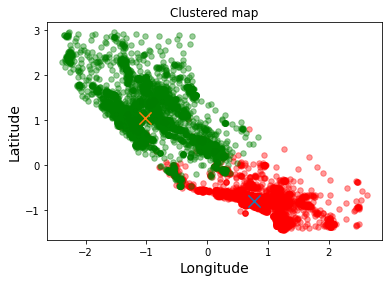

In [0]:
plot_clusters(mykmeans)

### Some educated guess on the result:
From the map we can see California is clustered into the **northern** and **southern** section. This is largely due to the two hotspots of real-estate industry:
The **bay area in the north** and the **LA in the south**, these two areas attract much investment and talents due to the tech industry in Silicon valley and the entertainment industry around LA

## The Elbow Curve

In [0]:
SSE_list = []

SSE_list.append(SSE)
for i in range(3, 10):
  kmeans_model = kmeans(k=i)
  kmeans_model.kmeans(housing_prepared)
  SSE_list.append(kmeans_model.SSE())

iterations:  16
iterations:  30
iterations:  44
iterations:  90
iterations:  50
iterations:  54
iterations:  63


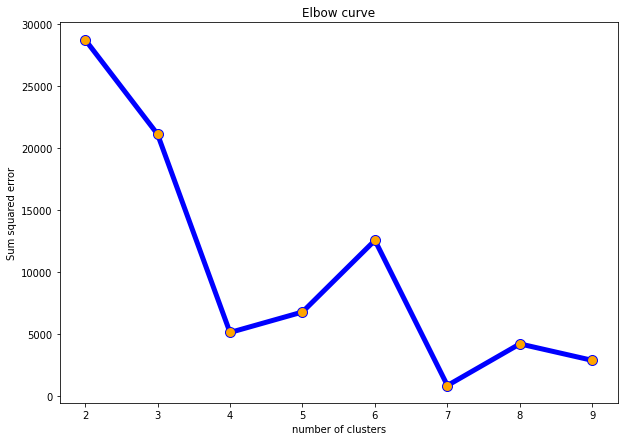

In [0]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(2,len(SSE_list)+2),SSE_list,marker='o',markerfacecolor='orange',markersize=10,lw=5,color='blue')
plt.title('Elbow curve')
plt.xlabel('number of clusters')
plt.ylabel('Sum squared error')
plt.show()

## 4 Clusters

In [0]:
# The above elbow graph suggests 4 clusters may be the most appropriate number

# cluster the data for k=4
mykmeans = kmeans(k=4, slack=0) # dist_measure = 'euclidean'
clusters, cent = mykmeans.kmeans(housing_prepared) # distances and centroids
print("centroids: ", cent)

means, stds = mykmeans.J()
print("means: ", means)
print("stds", stds)
SSE = mykmeans.SSE()
print("sum squared error", SSE)

iterations:  46
centroids:  [array([-1.01031774,  1.10362067,  0.05577792, -0.23999448, -0.24339192,
       -0.27495091, -0.25381988, -0.31912765, -0.404809  ,  0.14808629,
        0.53305498,  0.        ,  0.23729993,  0.0815588 ]), array([ 8.07177106e-01, -8.11495463e-01,  8.97631214e-02, -2.49440885e-01,
       -1.72984950e-01, -9.21638662e-02, -1.70622318e-01, -2.97143878e-01,
       -2.81293519e-01,  6.23676944e-01,  2.22273355e-01,  4.60193281e-04,
        0.00000000e+00,  1.53589508e-01]), array([-1.42411581e-02, -2.08371795e-01,  9.90840321e-02,  4.55517693e-02,
       -2.06956100e-01, -2.65020377e-01, -1.85700624e-01,  1.53331850e+00,
        1.72112113e+00,  6.09924417e-01,  6.11238909e-02,  3.28623069e-04,
        1.43936904e-01,  1.84686165e-01]), array([ 0.18934926, -0.15989462, -0.97984012,  2.48108821,  2.56584501,
        2.36818744,  2.55904298,  0.13867717,  0.0767907 ,  0.4580304 ,
        0.36219432,  0.        ,  0.08393919,  0.09583609])]
means:  [array([-1.010317

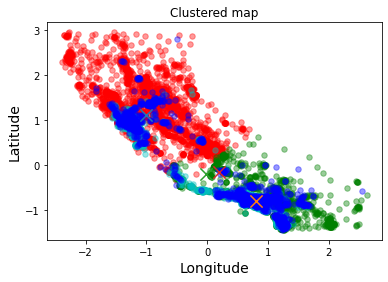

In [0]:
plot_clusters(mykmeans)

### Some educated guess on the result:
From this map we can see the 4 clusters denoted in different color represents the different areas in California:

*   The **bay area** in blue with a blue centroid
*   The **LA area** in blue with an orange centroid
*   The **other northern areas** in red with a red centroid
*   The **other southern areas** in green with a green centorid

## 10 Clusters

In [0]:
# Let's try cluster the data for k=10 to see if the silicon valley, SF, etc. are recognized as separate clusters

mykmeans = kmeans(k=10, slack=0) # dist_measure = 'euclidean'
clusters, cent = mykmeans.kmeans(housing_prepared) # distances and centroids
print("centroids: ", cent)

means, stds = mykmeans.J()
print("means: ", means)
print("stds", stds)
SSE = mykmeans.SSE()
print("sum squared error", SSE)

iterations:  83
centroids:  [array([ 0.32107648, -0.25884132, -1.45093606,  6.60715764,  6.23070216,
        6.07263859,  6.23556623,  0.44144072,  0.14242753,  0.44155844,
        0.4025974 ,  0.        ,  0.06493506,  0.09090909]), array([-1.16450749,  1.13185625,  1.07218781, -0.48135651, -0.45141842,
       -0.47306835, -0.45313724, -0.59038793, -0.5731982 ,  0.12589928,
        0.39253597,  0.        ,  0.39973022,  0.08183453]), array([ 0.30853055, -0.27758648, -0.97528455,  2.42460342,  2.54417418,
        2.30793972,  2.53017173,  0.1781075 ,  0.12541169,  0.47794994,
        0.36352801,  0.        ,  0.07151371,  0.08700834]), array([-0.68846746,  1.10071141, -0.69228215, -0.36504014, -0.39731233,
       -0.41380685, -0.4381721 , -0.44423242, -0.79772268,  0.07140332,
        0.87062566,  0.        ,  0.03287381,  0.02509721]), array([ 0.70496564, -0.82411742,  0.0750545 , -0.19412103, -0.31833235,
       -0.35997915, -0.2981867 ,  0.68495966,  0.97552151,  0.78105647,
       

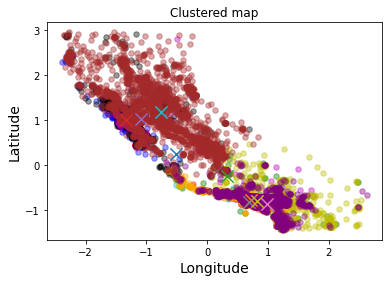

In [0]:
plot_clusters(mykmeans)

- - -
## 4. WRITING ON THE INTUITION FOR THE CALIFORNIA HOUSING CRISIS (10 pts)

This question is a qualitative one, and is intended to let you experiment with a real world clustering task. Hopefully it gives you some intuition as for how the preset number of clusters affects the clustering results. Too few clusters may not reveal the information that is in the data. Too many clusters may hurt data analysis as well, as it may not generalize (and in this sense, it is equivalent to over fitting).

Write at least one paragraph to demonstrate your intuition on the California Housing Crisis. You might also want to mention some possible solutions to solve it. You will receive credits based upon your insights and intuitions on this challenge. 



**Some thoughts:**
From the clustering map based on the California housing data, it is clearly shown that the average high housing price is largely drived up by a few hotspots of real estate, including the bay area in the north, and the LA area in the south. Housing is far more expensive in these metropolitan areas due to the high-earning industries (e.g. tech, entertainment, investment...) there, and foreign investments in real estates could be another contributing factor.

To attempt solving the housing crisis, one has to delve into the root of the cause: the imbalance between the well-paid new industries which attracts talents to move to California and the local community who may not share the benefits of these companies. If the government want to correct this imbalance, one straightforward way is to impose more tax on these industries and appropriate them as a housing fund for the homeless people. However, this would inevitably discourage the business, especially start-ups to stay in California, and would not be a welcomed side-effect for the California governemnt. 

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during their OH.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 3:...".

Best of luck and have fun!